Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Firstname Lastname | 01234567 | 11.05.2022, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 4 &ndash; Recurrent Neural Networks (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, A. Schörgenhumer<br>
<b>Date:</b> 02-05-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u4_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u4_utils.py</code> need to be installed.

<div class="alert alert-warning">
    <b>Important:</b> Set the random seed with <code>u4.set_seed(23)</code> to enable reproducible results in all tasks that incorporate randomness (e.g., t-SNE, splitting data intro train and test sets, initializing weights of a neural network, running the model optimization with random batches, etc.). You must use <code>23</code> as seed.
</div>

In [2]:
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

# Check minimum versions.
u4.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.23.5 (✓)
Installed pandas version: 1.4.4 (✓)
Installed PyTorch version: 2.0.0+cpu (✓)
Installed matplotlib version: 3.7.1 (✓)
Installed seaborn version: 0.12.2 (✓)


<a name="exercise-latch-sequence-set"></a><h2>The Latch Sequence Data Set</h2>
<p>In the accompanying excercise class, the <i>latch task</i> was presented. You'll be working with the same data set in this assignment. The original latch task was introduced by Hochreiter and Mozer:
<center>
    <cite>Sepp Hochreiter, Michael Mozer, 2001. A discrete probabilistic memory model for discovering dependencies in time. Artificial Neural Networks -- ICANN 2001, 13, pp.661-668.</cite>
</center></p>

<p>The essence of this task is that a sequence of inputs is presented, beginning with one of two symbols, <b>A</b> or <b>B</b>, and after a variable number of time steps, the model has to output a corresponding symbol. Thus, the task requires memorizing the original input over time. It has to be noted that in the <i>original</i> task desription, both class-defining symbols must only appear at the first position of an instance.</p>

<p>The modified version of this task used in this assignment is identical to the one discussed during the accompanying exercise, with the difference of a higher amount of possible targets. Defining arguments are:

<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this assignment)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>num_samples</code></th>
        <th>5000</th>
        <th>Amount of samples of the full dataset.</th>
    </tr>
    <tr>
        <th><code>num_instances</code></th>
        <th>56</th>
        <th>Amount of instances per sample (sample length).</th>
    </tr>
    <tr>
        <th><code>num_characters</code></th>
        <th>20</th>
        <th>Amount of different characters (size of the one-hot encoded vector).</th>
    </tr>
    <tr>
        <th><code>num_targets</code></th>
        <th>19</th>
        <th>Amount of different characters used as possible targets.</th>
    </tr>
    <tr>
        <th><code>seed</code></th>
        <th>23</th>
        <th>Random seed used to generate the samples of the data set.</th>
    </tr>
</table></p>

<div class="alert alert-warning">
    <b>Exercise 1.1. [8 Points]</b>
    <ul>
        <li>Generate a <i>latch sequence</i> data set with the properties as described in the table <i>above</i>.</li>
        <li>Visualize the last sequence of the data set in <i>tabular</i> form, with all $1$ in <b style="color:green">bold green</b> and all $0$ in <span style="font-weight: lighter">lighter</span> default font color.</li>
        <li>Visualize the <i>first</i> $20$ samples in a heatmap, once <i>without</i> and once <i>with</i> a corresponding prefix-mask.</li>
        <li>Interpreting the previous visualizations, which <i>character</i> of the chosen alphabet determines the <i>prefix</i>?</li>
    </ul>
</div>

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,t38,t39,t40,t41,t42,t43,t44,t45,t46,t47,t48,t49,t50,t51,t52,t53,t54,t55,t56
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

THIS IS SUB DATA (20, 56, 20)
The prefix is determined by the character with index 19


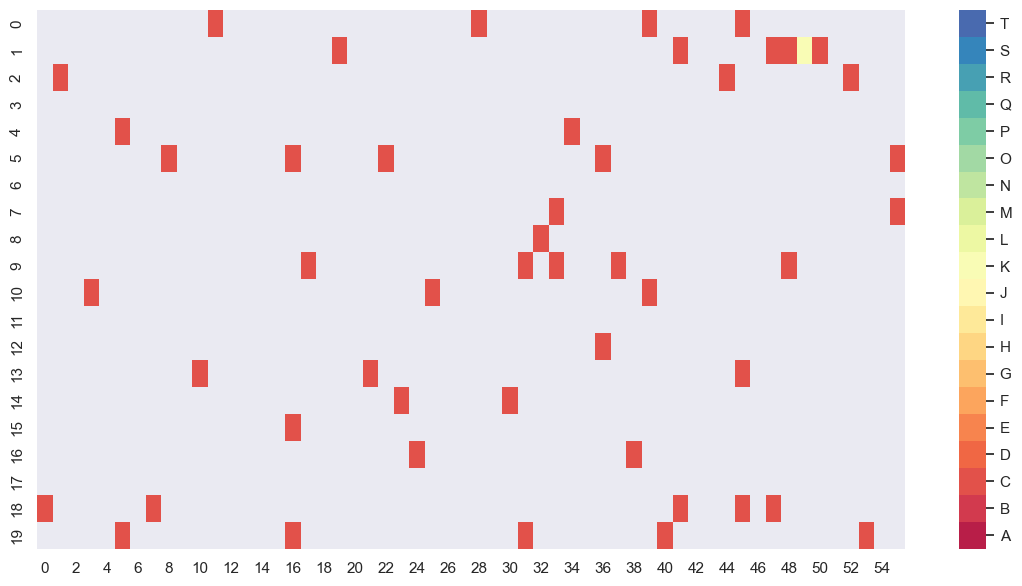

In [34]:
u4.set_seed(42)

# Generate latch sequence data set
dataset = u4.LatchSequenceSet(num_samples=5000, num_instances=56, num_characters=20, num_targets=19, seed=23)

# Visualize last sequence
last_sequence = dataset[-1][0].numpy()
df_last_sequence = pd.DataFrame(last_sequence.T, columns=[f"t{i}" for i in range(1, dataset.num_instances+1)])
df_last_sequence = df_last_sequence.style.applymap(lambda x: 'background-color : green' if x == 1 else '')
display(df_last_sequence)

# Visualize first 20 samples with and without prefix mask
num_samples_to_visualize = 20
sub_data = dataset[:num_samples_to_visualize][0].numpy()
print("THIS IS SUB DATA", sub_data.shape)
u4.plot_heatmap(data=pd.DataFrame(sub_data.argmax(axis=2)), figsize=(14, 7), prefix_mask=True)


# Determine prefix
print(f"The prefix is determined by the character with index {dataset.num_targets}")



your answer goes here

<div class="alert alert-warning">
    <b>Exercise 1.2. [7 Points]</b>
    <ul>
        <li>Linearly split the data set into a <i>training</i> and a <i>test</i> set in a ratio of $4 : 1$ (use a <code>SubsetRandomSampler</code> and a batch size of $48$).</li>
        <li>Compute and print the <i>amount of samples</i> of each of the respective sets and verify the $4 : 1$ split.</li>
        <li>Visualize the <i>character counts</i> of the <i>first</i> training minibatch appropriately. What is the count of the <i>prefix</i> character? Provide a formula as a function of the <i>batch_size</i> to compute the count of the <i>prefix</i> character.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<a name="exercise-latch-cnn"></a><h2>Tackling Sequence Data with CNNs</h2>
<p>During the accompanying exercise class, a <i>dense feed-forward</i> network was presented as some kind of baseline. Afterwards, recurrent architectures were applied. In this exercise, you'll be tasked with implementing a <i>convolutional</i> architecture for handling sequence data.</p>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [ ]:
class TheMightyDice(torch.nn.Module):
    """
    Dice roll "network" tailored to deliver random outcomes.
    """
    
    def __init__(self, output_size: int):
        super().__init__()
        self.__output_size = output_size
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.rand(size=(x.shape[0], self.__output_size), device=x.device)


def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))

<div class="alert alert-warning">
    <b>Exercise 2.1. [7 Points]</b>
    <ul>
        <li>Test a <code>TheMightyDice</code> instance on the latch sequence <i>test</i> set. Do you expect this result? Comment on your answer.</li>
        <li>Assume <i>uniformly</i> distributed targets. If a model would <i>always</i> predict the same class, what would the accuracy be?</li>
    </ul>
</div>

In [ ]:
# your code goes here

your answer goes here

<div class="alert alert-warning">
    <b>Exercise 2.2. [15 Points]</b>
    <ul>
        <li>Implement a class <code>CNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$192$ output channels and a configurable kernel size (specified as an argument to <code>__init__</code>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$192$ output channels and the same kernel size as the <i>1D convolution</i> at position $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>6</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>CNN</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters (use <code>count_parameters</code> from above). Use a <i>kernel size</i> of $1$.</li>
        <li>Repeat the same procedure with a second <code>CNN</code> but a <i>kernel size</i> of $3$.</li>
        <li>Hints:</li>
        <ul>
            <li>With the parameterized kernel size, you cannot hard-code the flattened number of elements for the linear layer input. Instead, you have to calculate it using the length of the input (<code>data_latch.num_instances</code>), which might be a good idea to pass into <code>__init__</code> as well. Each convolutional layer then reduces this length by <code>kernel_size - 1</code>.</li>
            <li><code>Conv1d</code> expects the minibatch input shape <code>(N, C, L)</code>, but the latch data has a minibatch shape of <code>(N, L, C)</code>. Thus, in your <code>forward</code> method, you will first have to transform the input minibtach into the correct shape before you can apply the network architecture. There are several ways to do this, e.g., <a href="https://pytorch.org/docs/stable/generated/torch.transpose.html">transposing</a> or <a href="https://pytorch.org/docs/stable/generated/torch.movedim.html">moving dimensions</a>.</li>
        </ul>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 2.3. [12 Points]</b>
    <ul>
        <li>Implement a class <code>PoolCNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$16$ output channels and a kernel size of $3$</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html">1D adaptive max pool</a></td>
            <td>output size of $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>5</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>PoolCNN</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters.
        <li>Compare the results of the <code>PoolCNN</code> network with those of the two <code>CNN</code> networks. What do you observe? Interpret and discuss your results regarding all three networks.</li>
    </ul>
</div>

In [ ]:
# your code goes here

your answer goes here

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [ ]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader) -> pd.DataFrame:
    """
    Auxiliary function for collecting gradient magnitudes of a corresponding model w.r.t. the network input.
    
    :param model: model instance to be used for collecting gradients
    :param device: device to use for gradient collection
    :param loader: data loader supplying the samples used for collecting gradients
    :return: data frame comprising the gradient magnitudes of the loss function w.r.t. each input element
    """
    model_state = model.training
    model.train()
    model.zero_grad()
    
    # Set random seed for reproducibility (data iteration).
    u4.set_seed(23)
    
    # Iterating over the data set and computing the corresponding gradients.
    device, gradients = next(model.parameters())[0].device, []
    criterion = torch.nn.CrossEntropyLoss()
    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)
        
        # Prepare network input for gradient recording.
        data.requires_grad_(True)
        data.register_hook(lambda x: gradients.append(x.cpu().abs()))

        # One forward
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        model.zero_grad()
    
    # Reset model to its original state and return averaged collected gradients.
    model.train(mode=model_state)
    return pd.DataFrame(torch.cat(gradients, dim=0).mean(dim=2).numpy())

<div class="alert alert-warning">
    <b>Exercise 2.4. [8 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>CNN</code> using a <i>kernel size</i> of $3$ and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [ ]:
# your code goes here

your answer goes here

<a name="exercise-latch-lstm"></a><h2>Tackling Sequence Data with LSTMs</h2>
<p>During the accompanying exercise class, the <i>Long Short-Term Memory (LSTM)</i> was presented as a quite prominent and often used architecture in the recurrent case. It was designed and published by <a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf">Hochreiter and Schmidhuber</a>:
    <center>
        <cite>
            Hochreiter, S. and Schmidhuber, J., 1997. Long short-term memory. Neural computation, 9(8), pp.1735-1780.
        </cite>
    </center></p>

<p>It has to be noted, that the most crucial part of the LSTM, the <i>constant error carousel (CEC)</i>, was already discussed during <a href="https://people.idsia.ch//~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf">Hochreiter's diploma thesis</a> (in German):
    <center>
            <cite>
                Hochreiter, S., 1991. Untersuchungen zu dynamischen neuronalen Netzen. Diploma, Technische Universität München, 91(1).
            </cite>
    </center></p>

<p>In contrast to most other recurrent architectures like the Elman RNN, the <i>LSTM</i> is a bit more complex, but equally more powerful:
    <center>
        \begin{equation}
            \begin{split}
                i_{t} &= \sigma{\left(W_{ii}x_{t} + b_{ii} + W_{hi}h_{t-1} + b_{hi}\right)} \\
                \color{red}{f_{t}} &\color{red}{= \sigma{\left(W_{if}x_{t} + b_{if} + W_{hf}h_{t-1} + b_{hf}\right)}} \\
                g_{t} &= \tanh{\left(W_{ig}x_{t} + b_{ig} + W_{hg}h_{t-1} + b_{hg}\right)} \\
                o_{t} &= \sigma{\left(W_{io}x_{t} + b_{io} + W_{ho}h_{t-1} + b_{ho}\right)} \\
                c_{t} &= \color{red}{f_{t}\odot{}}c_{t-1} + i_{t}\odot{}g_{t} \\
                h_{t} &= o_{t}\odot{}\tanh{\left(c_{t}\right)}
            \end{split}
        \end{equation}
    </center></p>

<p>We are using the implementation provided by PyTorch, more information may be found in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM">official documentation</a>. It has to be noted, the the <i>original</i> formulation did <i>not</i> contain an additional <i>forget gate</i> $f_{t}$ (see equations above), as this completely destroys the <i>constant error carousel</i> – it was introduced by <a href="https://www.mitpressjournals.org/doi/pdfplus/10.1162/089976600300015015">Gers et al.</a>:
<center>
    <cite>Gers, F.A., Schmidhuber, J. and Cummins, F., 1999. Learning to forget: Continual prediction with LSTM.
    </cite>
</center></p>
<p>Nonetheless, for <i>some</i> tasks, the forget gate seems to provide a useful addition. Hence, in this exercise you'll be tasked with activating the <i>forget gate</i> and interpreting the results.</p>

<div class="alert alert-warning">
    <b>Exercise 3.1. [13 Points]</b>
    <ul>
        <li>Implement a class <code>LSTM</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">LSTM</a></td>
            <td>$48$ memory cells and a configurable initial forget gate bias (specified as an argument to <code>__init__</code>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>3</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train an <code>LSTM</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters. Use an initial forget gate bias of $0.0$. Do you expect the resulting performance?</li>
        <li>Hint: You now want to use the forget gate, so do <i>not</i> disable the gradient computation!</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 3.2. [10 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>LSTM</code> and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [ ]:
# your code goes here

your answer goes here

<div class="alert alert-warning">
    <b>Exercise 3.3. [10 Points]</b>
    <ul>
        <li>Use the already trained <code>LSTM</code> instance from the beginning of this section for collecting its gradients w.r.t. the network input using the latch sequence training set, i.e., collect gradients one more time but now using the trained model.</li>
        <li>Visualize (in a single plot) the the newly collected gradients together with the previous gradients of the <i>freshly</i> created <code>LSTM</code> instance. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [ ]:
# your code goes here

your answer goes here

<div class="alert alert-warning">
    <b>Exercise 3.4. [10 Points]</b>
    <ul>
        <li>Train an <code>LSTM</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters. Use an initial forget gate bias of $1.0$. Do you expect the resulting performance?</li>
        <li>Analogous to above, visualize (in a single plot) the gradients of both a <i>freshly</i> created <code>LSTM</code> instance and the trained model. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [ ]:
# your code goes here

your answer goes here